In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from CustomerReviews import Reviews
import warnings
warnings.filterwarnings("ignore")
from imp import reload

C:\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


>用户体验的工作可以说是用户需求和用户认知的分析。而消费者的声音是其中很重要的一环，它包含了用户对产品的评论，不管是好的坏的，都将对我们产品的改进和迭代有帮助。另外任何事情都要考虑金钱成本和人力成本，因此我希望能通过机器学习的算法来辅助分析，对用户的评论数据进行提炼和洞察。



## 一、数据获取和清洗

现在爬虫泛滥，网络公开数据的获取并不再是一个难题。简单点可以利用一些互联网的爬虫服务（如神箭手、八爪鱼等），复杂点也可以自己写爬虫。这里我们用爬虫来获取京东的评论数据。相对于亚马逊而言，京东比较坑。第一个坑是京东的反爬虫还不错，通过正常产品网址进去的那个评论列表是几乎爬不出数据来的，所有大部分网络爬虫服务都止步于此。第二个坑是一款产品的评论数只要超过**一万条**，那么京东就只会显示前**一千条**，没有公开的数据，那你爬虫技术再厉害也没办法，除非开着爬虫定时增量更新数据。

自己写爬虫的好处就是可以避免掉进第一个坑，但是第二个坑没办法。这里我爬取了 `小米MIX` 和 `小米MIX2` 的评论数据(最新的几款手机我都爬取了，需要的请戳后台)，其中 `小米MIX` 共1578条，`小米MIX2` 共3292条。

本文通过分析这些数据预期完成如下几个目标

- 1、数据清洗后的好评率
- 2、好/中/差评的概览
- 3、典型意见分析

首先来看看MIX2的大致情况：

In [43]:
data=pd.read_csv('.\\data\\小米MIX2.csv')
# 爬取的数据包含的字段
print('包含字段:\n'+'||'.join(data.columns))
# 将评论创建的时间转化为时间格式
data['creationTime']=pd.to_datetime(data['creationTime'])
# days 是从购买到首次评论的天数，score是用户的评分，1-5分
print(data[['days','score']].describe())
data[['content','productColor']].describe()

包含字段:
pid||guid||creationTime||days||content||nickname||productColor||referenceId||referenceName||referenceTime||score||userClient||userLevelId||userLevelName||userProvince||userRegisterTime||版本||购买方式
              days        score
count  3497.000000  3497.000000
mean      9.056048     4.877323
std      11.497973     0.581064
min       0.000000     1.000000
25%       1.000000     5.000000
50%       4.000000     5.000000
75%      10.000000     5.000000
max      42.000000     5.000000


,content,productColor
count,3497,3497
unique,3309,1
top,好,黑
freq,24,3497


可以看到一共有3497条评论，其中有些评论内容还是完全相同的。用户大概在购买9天后后评论（可能与到货日期有关），平均打分为4.87分，评论里面有些完全相同的，小米MIX2只有一种颜色等等。

接下来我们先做第一件事。

In [44]:
comments=Reviews(texts=data['content'],scores=data['score'],creationTime=data['creationTime'])
comments.describe()
# 这里的 `Reviews` 是作者自己造的轮子，封装了很多NLP的算法，便于评论语料的分析。

样本数              3292
平均字符数            38.5
好评       3181(96.63%)
中评          61(1.85%)
差评          50(1.52%)
dtype: object

其中好评的评分为4-5分，差评的评分为1分(京东的准则)。

可以看到。。。。

但是仔细检查评论，我们会发现有很多垃圾评论、无效评论，比如：
未获得更准确的分析，我们需要尽可能的去掉这些垃圾评论。可以看到它们具有类似的关键词，一个简单的想法就是根据这些关键词的数量来判断。当然这里并不需要找到所有的垃圾评论关键词，只需要给定少量的，然后通过算法找到剩下的即可。

![]('垃圾评论关键词.png')

未获得更准确的分析，我们需要尽可能的去掉这些垃圾评论。可以看到它们具有类似的关键词，一个简单的想法就是根据这些关键词的数量来判断。当然这里并不需要找到所有的垃圾评论关键词，只需要给定少量的，然后通过算法找到剩下的即可。

![]('垃圾评论关键词.png')


In [45]:
warnings.filterwarnings("ignore")
# 解决一词多义问题以及统一产品特征名词。比如触摸屏-->触屏等
comments.replace('synonyms.txt')
# 分词。此处用的是结巴分词工具，添加了手机领域的专有词、以及产品特点词语，比如磨砂黑、玫瑰金
comments.segment(product_dict='mobile_dict.txt',stopwords='.\\stopwords\\chinese.txt',add_words=color)
# 去除无效评论
initial_words=['经济','杂交','今生今世','红红火火','彰显','荣华富贵','仰慕','滔滔不绝','永不变心','海枯石烂','天崩地裂']
comments.drop_invalid(initial_words=initial_words,max_rate=0.6)
comments.describe()

样本数              3175
平均字符数            39.3
好评       3065(96.54%)
中评          60(1.89%)
差评          50(1.57%)
dtype: object

还有一些评论，虽然内容是差评，但是给的分值并不是，很多时候，这是京东的评论机制造成的。现在我们来看看能否用算法找出这些评论。

在NLP领域中，有一个课题叫做情感分析（sentiment analysis）, 它可以判断一句话的情感方向，是正面的还是负面的。有大神专门用电商评论训练了一个开源的情感分析包snownlp, 我们先来看看这个包效果怎样。

In [5]:
len(comments)

2448

acc = 92.60%, AUC = 0.157


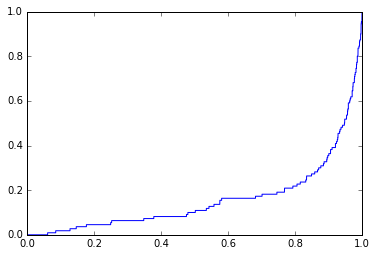

In [4]:
from sklearn import metrics
ss=comments.sentiments(method='snownlp')
# 此处是典型的样本不平衡问题，所以预测概率需要 “再缩放”
acc=metrics.accuracy_score(comments.scores,pd.cut(ss,[-0.1,0.0158,0.0347,1],labels=['差评','中评','好评']))
fpr, tpr, thresholds = metrics.roc_curve(comments.scores.replace({'好评':-1,'中评':1,'差评':1}), ss)
auc=metrics.roc_auc_score(comments.scores.replace({'好评':-1,'中评':1,'差评':1}), ss)
print('acc = {:.2f}%, AUC = {:.3f}'.format(acc*100,auc))
plt.plot(fpr,tpr)

嗯嗯，准确率为95.63%，比全部预测为好评还要低。AUC也小于0.5，简单来讲就是比随机预测结果还要差~ 为获得更好的结果，估计还得用手机的评论专门训练一个模型。

## 二、好/中/差评的语义理解

好评 的关键词为：手机|小米|京东|没有|屏幕|感觉|手感|有点|系统|喜欢|满意|支持|问题|速度|使用|边框|抢到|拍照|摄像头|东西
中评 的关键词为：手机|小米|没有|屏幕|还有|感觉|问题|摄像头|拍照|还好|设计|时候|拿到|电池|京东|解决|机器|使用|有点|微信
差评 的关键词为：手机|京东|没有|小米|无法|屏幕|售后|问题|出来|客服|时间|软件|模式|使用|不了|电话|微信|充电|虚拟|只能


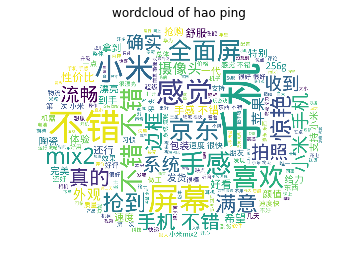

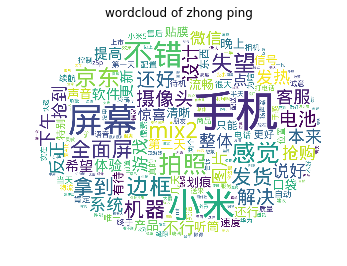

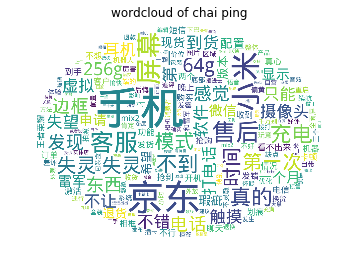

In [7]:
%matplotlib inline
for k in ['好评','中评','差评']:
    keywords=comments.get_keywords(comments.scores==k)
    print('{} 的关键词为：'.format(k)+'|'.join(keywords))
    comments.genwordcloud(comments.scores==k,filename='wordcloud of {}'.format(k));

从词云中可以看到差评集中在客服、实体店、质量、感觉等，但是并不知道具体是啥，也不知道不好的程度。另外词云中的词没有区分名字、形容词等，

## 三、典型意见分析

一个产品的意见通常是......



In [4]:
features=comments.get_product_features()
print(features)

['总体', '256g', '手感', '质量', '机器', '屏幕', '物流', '小米', '质感', '有点', '效果', '前置', '性价比', '产品', '速度', '外观', '想象', '手机', '气', '价格', '评价', '手', '性能', '体验', '陶瓷', '颜值', '空间', '整体', '摄像头', '东西', '边框', '感觉', '系统']


可以看到用户的评价除下正常的手机特征外，有：边框、颜值、质感、256g、陶瓷、想象等。详细一点，我们还可以看到具体的内容


In [13]:
texts_fw=comments.find_keywords('边框')
print(texts_fw.head(15))
comments.scores[texts_fw.index].value_counts()

1                           上边框的圈角有时看着像不对称样
2                         打开手机给我的感觉是屏幕边框比较小
15                       屏幕边缘和边框的边缘还是有不少距离的
16                         一开始收到的时候看见确实边框大点
22     网上说的黑边框实际看起来还是可以接受 | 毕竟边框在摔落时能抵抗不少冲击
47                             屏幕和边框之间有少许残胶
52                 三边框宽 | mix2宣传照的边框你能p更细点吗
64                            这外边框比宣传图大不止一点
90                             的机身边框也采用弧度设计
95             其实连超窄边框都没有做到 | 屏幕外的玻璃离边框是挺近的
98              我觉得无边框不适合我 | 这个边框大一点反而不容易误触
229                              就是屏幕大了边框窄了
244                            不过边框控制的不是很理想
283                          大屏幕无边框确实看起来很好看
319                            mix2的边框比一代粗了
Name: content, dtype: object


好评    77
中评     4
差评     2
Name: score, dtype: int64

可以统一计算各个特征的好评率

In [8]:
features_new=list(set(features)-set(['有点','手','物流','想象','速度快','气'])|set(['拍照','照相','内存','续航','全面屏']))
features_opinion,feature_corpus=comments.features_sentiments(features_new,method='score')
print(features_opinion.sort_values('p_positive'))

     total mention_count p_positive  p_negative
机器    3175            18   0.777778    0.111111
续航    3175            16     0.8125       0.125
整体    3175            17   0.823529    0.117647
256g  3175            37   0.891892   0.0810811
屏幕    3175           154   0.902597   0.0324675
东西    3175            47   0.914894   0.0638298
前置    3175            26   0.923077   0.0384615
手机    3175           336   0.925595   0.0386905
边框    3175            83   0.927711   0.0240964
产品    3175            28   0.928571           0
价格    3175            15   0.933333           0
拍照    3175            50       0.94        0.02
照相    3175            18   0.944444   0.0555556
性能    3175            18   0.944444   0.0555556
摄像头   3175            81   0.950617   0.0246914
系统    3175            87   0.954023   0.0114943
体验    3175            47   0.957447   0.0212766
全面屏   3175            54   0.962963   0.0185185
小米    3175           329   0.963526   0.0121581
感觉    3175           174   0.965517   0.

可以看到提及最多的特征依次为：**感觉、屏幕、速度、手感、系统、边框、摄像头、全面屏、拍照、体验、256g、外观、质量、性价比**

其中比较好的有：**性价比、质量、手感、速度、外观、感觉**

其中稍差些的有：**256g、屏幕、边框、拍照、摄像头、系统、体验、全面屏**

In [23]:
print(features_opinion[features_opinion['mention_count']>=30].sort_values('p_positive'))
print('好评占比大于所有样本(好评率96.54%)的特征：')
print(features_opinion[(features_opinion['mention_count']>=30)&(features_opinion['p_positive']>=0.9654)].index)
print('好评占比小于所有样本(好评率96.54%)的特征：')
print(features_opinion[(features_opinion['mention_count']>=30)&(features_opinion['p_positive']<0.9654)].index)

     total mention_count p_positive  p_negative
256g  3175            37   0.891892   0.0810811
屏幕    3175           154   0.902597   0.0324675
东西    3175            47   0.914894   0.0638298
手机    3175           336   0.925595   0.0386905
边框    3175            83   0.927711   0.0240964
拍照    3175            50       0.94        0.02
摄像头   3175            81   0.950617   0.0246914
系统    3175            87   0.954023   0.0114943
体验    3175            47   0.957447   0.0212766
全面屏   3175            54   0.962963   0.0185185
小米    3175           329   0.963526   0.0121581
感觉    3175           174   0.965517   0.0114943
外观    3175            36   0.972222           0
速度    3175           148   0.972973  0.00675676
效果    3175            63   0.984127           0
手感    3175           124   0.991935  0.00806452
质量    3175            36          1           0
性价比   3175            34          1           0
评价    3175            41          1           0
好评占比大于所有样本(好评率96.54%)的特征：
Index(['手感', '

In [32]:
print('='*40+'256g'+'='*40)
print('//'.join(comments.find_keywords('256g').head(30)))
print('='*40+'屏幕'+'='*40)
print('//'.join(comments.find_keywords('屏幕').head(30)))
print('='*40+'边框'+'='*40)
print('//'.join(comments.find_keywords('边框').head(30)))
print('='*40+'拍照'+'='*40)
print('//'.join(comments.find_keywords('拍照').head(30)))

========================================256g========================================
我购买的是最高配256g产品//不过256g这个价格的手机也就这款了//运气好看到256g版的突然有货了//是256g的没错//内存有256g版本的//但是256g真心用不了//等了几天抢了256g的//结果只有256g的//去论坛看大家说256g的是现货结果当时去买总是提示抢不到//只好买256g的版本了//内存256g也很大//一看256g有货//买的256g的//终于买到了256g手机//顶配版居然没有256g的//冲着835和256g买的//好不容易抢到哦256g的//就是给我货发错了256g变64g了//所以我抢的是256g的内存//所以这次索性买的256g的爽一下//以为内存256g是最高版//拿到手机首先确认了是256g没发错货//买256g发64g晕死//我的是256g的//没想到256g有货//我买的256g的//就怕将我256g发成64g的//货没有发错是256g版本//抢到了一部256g的//我的256g的没有被送成64的
========================================屏幕========================================
打开手机给我的感觉是屏幕边框比较小//缺点就是屏幕太脆弱//但是荣耀8屏幕有点小//应该是屏幕的问题//所以从屏幕正面看过去//圆角的屏幕从视觉上还需要适应一下 | 9的屏幕有些app在使用时会出问题//可以说mix2的屏幕跟小米6机身差不多大//但解决了一代用屏幕共振传音小的问题//再加个屏幕的大黑边 | 新mix2的屏幕就是泥巴屏//就是自拍需要翻转屏幕略显麻烦//就是屏幕比较长点稍微宽窄点之外没有任何特色 | 不过还好屏幕没有偏色发黄的感觉//夜景液晶屏幕显示较差//感觉屏幕小好多了//无非都是屏幕上下拉大//还好不过这屏幕6//不然抛开屏幕来说的话//除了屏幕颜色偏黄外//但是能点亮的屏幕距离玻璃的外沿还有较大的一段距离 | 我相信未来的手机是没有屏幕的//这个屏幕下面有点偏黄 | 左上角屏幕下似乎有一个很的小絮状物被封装进了屏幕和玻璃之间//但屏幕更大些//不过屏幕太大了//我的屏幕是

In [33]:
print('='*40+'性价比'+'='*40)
print('//'.join(comments.find_keywords('性价比').head(30)))
print('='*40+'质量'+'='*40)
print('//'.join(comments.find_keywords('质量').head(30)))
print('='*40+'手感'+'='*40)
print('//'.join(comments.find_keywords('手感').head(30)))
print('='*40+'速度'+'='*40)
print('//'.join(comments.find_keywords('速度').head(30)))
print('='*40+'外观'+'='*40)
print('//'.join(comments.find_keywords('外观').head(30)))

========================================性价比========================================
小米性价比还是很高的//确实性价比还是高的//感觉性价比比较高//mix2性价比绝对不如米6//小米性价比还是高//的确性价比超高//小米手机性价比很高哦//而且跟水果机相比还是性价比不错的//绝对比水果性价比高//小米mix2这款性价比目前算高的了 | 小米mix2这款手机性价比做的很好了//论性价比无疑是小米6//物美价廉好东西性价比高//指纹识别后盖很漂亮老人机外观漂亮字体大分辨率高性价比高//这款性价比如何自己想//总之性价比还挺不错的//又一款高性价比的小米手机//物流很快性价比超高的//一款性价比超高//小米的手机就是性价比高//64g版性价比高//东西的性价比高//这个性价比和颜值//小米手机性价比很高//手机性价比还是很高的//不过他说性价比高//国民手机功能齐全黑科技金属机身信号稳定通话质量好性价比高铃声大//仍然是性价比之王//极具性价比的手机//手机性价比高//超高性价比之慨
========================================质量========================================
通话质量也没问题//手机质量绝对没问题//很好下次还会购买物流很快质量很好//商品质量好//货还没有试不知道质量如何到时再评论吧//比一代通话质量好了很多//所以大家就当作是产品质量合格的意思来看就行了//通话质量相比1确实好了不少//缺点是摄像成像质量被华为前一代旗舰p9秒成渣//但愿质量不让我失望//因为做工和质量欠缺//中途因为质量问题换过一次//商品质量好//但是通话质量和照相提升太多//通话质量没试//通话质量也相当优秀//通话质量都比1有提高//希望质量过关//国民手机功能齐全黑科技金属机身信号稳定通话质量好性价比高铃声大//小米近几年的产品质量改进挺大的//小米手机质量不用说//国产机的质量还是有待于进一步加强//商品质量好//希望质量好//机子做的质量还行//服务质量速度没的说//但是真的是拍摄质量差到不能看//通话质量不错//但附赠的套质量一般//就是不知道质量如何
==============================